In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
import display
import dataloader

データロード

In [4]:
thermal_img_files = dataloader.get_img_files(dir_path="./images/modules",gray=False)
thermal_img_files_gray = dataloader.get_img_files(dir_path="./images/modules",gray=True)

In [5]:
type(thermal_img_files), len(thermal_img_files)

(dict, 158)

データの加工

In [6]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

In [7]:
flatten_thermal_data = {k: v.reshape(-1,3) for k, v in thermal_img_files.items()}
scaled_flatten_thermal_data = {k: scaler.fit_transform(v.reshape(-1,3)) for k, v in thermal_img_files.items()}

In [8]:
type(flatten_thermal_data), len(flatten_thermal_data)

(dict, 158)

In [9]:
all_thermal_data = np.concatenate([*flatten_thermal_data.values()])
scaled_all_thermal_data = np.concatenate([*scaled_flatten_thermal_data.values()])

In [10]:
type(all_thermal_data), len(all_thermal_data)

(numpy.ndarray, 84271)

In [11]:
def display_distributions(data, filepath="out.jpg", show=True):
    fig = plt.figure(facecolor="w")
    ax = fig.add_subplot(1,1,1)
    for i in range(data.shape[1]):
        ax.hist(data[:,i], bins = 100, alpha = 0.5)
    ax.axvline(x = data.mean(), 
               color = 'green', 
               alpha = 0.8, 
               linestyle = '--', 
               label = 'Mean')
    ax.axvline(x = data.mean() - 2*data.std(ddof=1), 
               color = 'orange', 
               alpha = 0.8, 
               linestyle = ':', 
               label = '2σ')
    ax.axvline(x = data.mean() + 2*data.std(ddof=1), 
               color = 'orange', 
               alpha = 0.8, 
               linestyle = ':')
    ax.set_title("Distribution of Thermal pixel values")
    ax.set_xlabel('pxil values')
    ax.set_ylabel('freq')
    ax.legend(loc='upper right')
    plt.savefig(filepath)
    if show: 
        plt.show()
    else:
        plt.close()

温度分布の確認（個別）

In [12]:
#for k, v in flatten_thermal_data.items():    
for k in list(flatten_thermal_data.keys())[:10]:
    print(k)    
    v = flatten_thermal_data[k]
    filepath = "./hist/hist_" + k
    display_distributions(v, filepath, show=False)

63.jpg
189.jpg
77.jpg
162.jpg
176.jpg
88.jpg
200.jpg
201.jpg
188.jpg
76.jpg


温度分布の確認（全体）

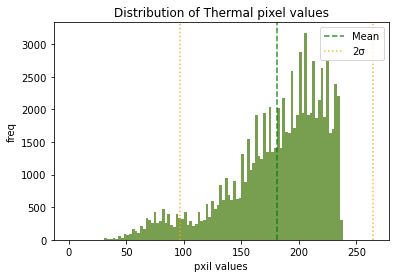

In [14]:
display_distributions(all_thermal_data, "hist_all_thermal_data.jpg")

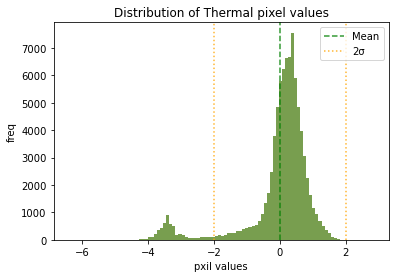

In [15]:
display_distributions(scaled_all_thermal_data, "hist_scaled_all_themal_data.jpg")

個別画像の分析

In [17]:
input_file = "72.jpg"
#input_file = "12.jpg"
#input_file = "126.jpg"
#input_file = "130.jpg"

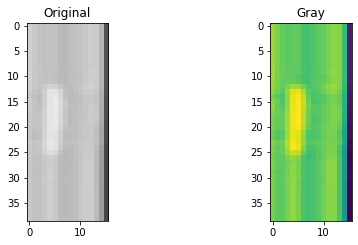

In [18]:
fig = plt.figure(figsize=(16,8),facecolor="w")
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(thermal_img_files[input_file])
ax1.set_title("Original")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(thermal_img_files_gray[input_file])
ax2.set_title("Gray")
plt.show()

In [20]:
def get_KMeans_results(inputs):
    from sklearn.cluster import KMeans
    pred = KMeans(n_clusters=5).fit(inputs)
    clusters = []
    for n in range(pred.n_clusters):
        clusters.append(np.array([data.tolist() for label, data in zip(pred.labels_,inputs) if label==n]))
    return clusters, pred

In [21]:
clusters, pred = get_KMeans_results(flatten_thermal_data[input_file])

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

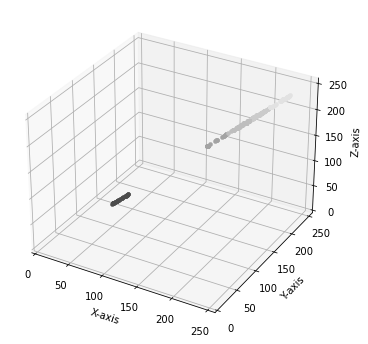

In [23]:
#display.plot_2d_scatters_for_clusters(clusters, pred)
display.plot_3d_scatters_for_clusters(clusters, pred)

In [24]:
centers = np.uint8(pred.cluster_centers_)
img_clustered = centers[pred.labels_]
img_clustered = img_clustered.reshape(thermal_img_files[input_file].shape)

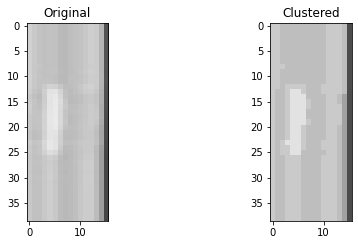

In [25]:
fig = plt.figure(figsize=(16,8),facecolor="w")
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(thermal_img_files[input_file])
ax1.set_title("Original")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img_clustered)
ax2.set_title("Clustered")
plt.show()

In [26]:
import itertools

In [27]:
def get_Euclid_distance(pairs, data):
    vec = data[pairs[0]] - data[pairs[1]]
    return np.linalg.norm(vec)

In [28]:
def get_pair_distances(data):
    pair_distances = []
    for pairs in itertools.combinations(range(len(data)),2):
        distance = get_Euclid_distance(pairs, data)
        pair_distances.append(distance)
    return np.array(pair_distances)

In [29]:
%%time
pair_distances = get_pair_distances(flatten_thermal_data[input_file])

CPU times: user 1.06 s, sys: 5.16 ms, total: 1.07 s
Wall time: 1.07 s


In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [31]:
def hierarchical_clustering(pair_distances, threshold=100, method="ward"):
    Z = linkage(pair_distances,method)
    clusters = fcluster(Z,threshold,criterion="distance") - 1
    return clusters, Z

In [32]:
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import squareform

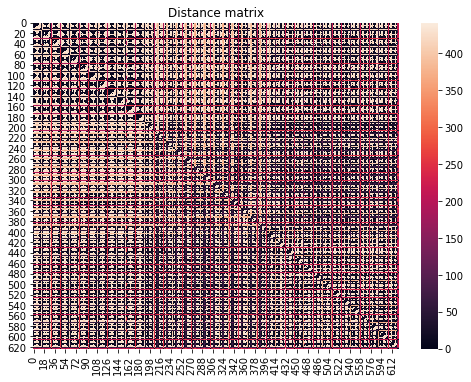

In [33]:
fig = plt.figure(figsize=(18,6),facecolor="w")
ax1 = fig.add_subplot(121)
ax1.set_title("Distance matrix")
sns.heatmap(squareform(pair_distances),annot=False)
plt.show()

In [34]:
clusters, Z = hierarchical_clustering(pair_distances)

In [37]:
clusters.max()

43

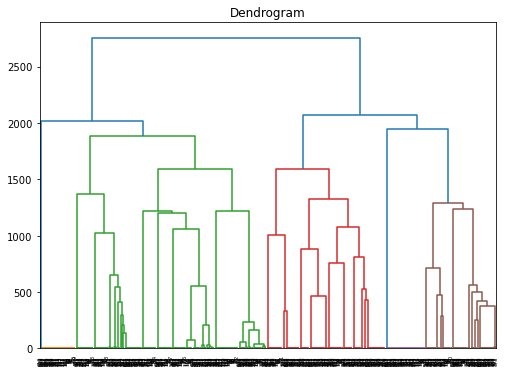

In [36]:
fig = plt.figure(figsize=(18,6),facecolor="w")
ax2 = fig.add_subplot(122)
ax2.set_title("Dendrogram")
dendrogram(Z)
plt.show()